### Random Forest yfinances Data

In [27]:
# Import Libraries 
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn import metrics 
import pyodbc 
from sklearn.linear_model import LinearRegression
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler


In [37]:
dat = yf.Ticker("NVDA")
df = yf.download(["NVDA"], period='12mo', interval='1d') # Por hora o por minuto, o por dia 
df[('Prev Close', 'NVDA')] = df[('Close', 'NVDA')].shift(1)  # Shifted by 1 to use previous day's close to predict today's
df.dropna(inplace=True)  # Remove rows with NaN values
df.tail()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Prev Close
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2025-04-02,110.419998,111.980003,106.790001,107.290001,220601200,110.150002
2025-04-03,101.800003,105.629997,101.599998,103.510002,338769400,110.419998
2025-04-04,94.309998,100.129997,92.110001,98.910004,532273800,101.800003
2025-04-07,97.639999,101.750000,86.620003,87.459999,609039800,94.309998
2025-04-08,100.264999,105.849998,98.580002,103.805000,325914276,97.639999


In [8]:
import pyodbc 


try:
    with pyodbc.connect(r'DRIVER={ODBC Driver 17 for SQL Server};SERVER=localhost;DATABASE=stock_market;Trusted_Connection=yes;')  as conn: # Si se pierde la conexion, cierra la sesion
        cursor = conn.cursor()
        # Method 2: Using itertuples() - faster than iterrows()
        for row in df.itertuples():
            print(f"Index: {row.Index}")
            print(row)
            
            data = {
                'ticker': 'NVDA',
                'date': row.Index,
                'close': row[1],
                'high': row[2],
                'low': row[3],
                'open': row[4],
                'volume': row[5]
            }
            print(data)
            cursor.execute("""
                INSERT INTO StockPrices (Ticker, "Date", "Close", "High", "Low", "Open", Volume)
                SELECT ?, ?, ?, ?, ?, ?, ?
                WHERE NOT EXISTS (
                    SELECT 1 FROM StockPrices 
                    WHERE Ticker = ? AND Date = ?
                )
            """, 
            data['ticker'], data['date'], data['close'], data['high'],
            data['low'], data['open'], data['volume'],
            data['ticker'], data['date'])

            cursor.execute("""
            UPDATE StockPrices
            SET     
                "Close" = COALESCE("Close", ?),
                "High" = COALESCE("High", ?),
                "Low" = COALESCE("Low", ?),
                "Open" = COALESCE("Open", ?),
                "Volume" = COALESCE("Volume", ?)
            WHERE Ticker = ? AND "Date" = ?
            """, data['close'], data['high'],
            data['low'], data['open'], data['volume'], data['ticker'], data["date"])
        
            if cursor.rowcount > 0:
                print("New record inserted successfully")
            else:
                print("Record already exists - no insertion made")
            
except pyodbc.Error as e:
    print(f"Database error: {e}")

Index: 2024-04-09 00:00:00
Pandas(Index=Timestamp('2024-04-09 00:00:00'), _1=85.3259506225586, _2=87.60620698800746, _3=82.99472376686872, _4=87.41326961083752, _5=503547000, _6=87.10437774658203)
{'ticker': 'NVDA', 'date': Timestamp('2024-04-09 00:00:00'), 'close': 85.3259506225586, 'high': 87.60620698800746, 'low': 82.99472376686872, 'open': 87.41326961083752, 'volume': 503547000}
New record inserted successfully
Index: 2024-04-10 00:00:00
Pandas(Index=Timestamp('2024-04-10 00:00:00'), _1=87.01040649414062, _2=87.3712879556285, _3=83.68149867040677, _4=83.89843024698811, _5=431929000, _6=85.3259506225586)
{'ticker': 'NVDA', 'date': Timestamp('2024-04-10 00:00:00'), 'close': 87.01040649414062, 'high': 87.3712879556285, 'low': 83.68149867040677, 'open': 83.89843024698811, 'volume': 431929000}
New record inserted successfully
Index: 2024-04-11 00:00:00
Pandas(Index=Timestamp('2024-04-11 00:00:00'), _1=90.58623504638672, _2=90.70919574606373, _3=86.89745219051976, _4=87.39128560717941, _

In [9]:
x = df["Prev Close"]
y = df["Close"]

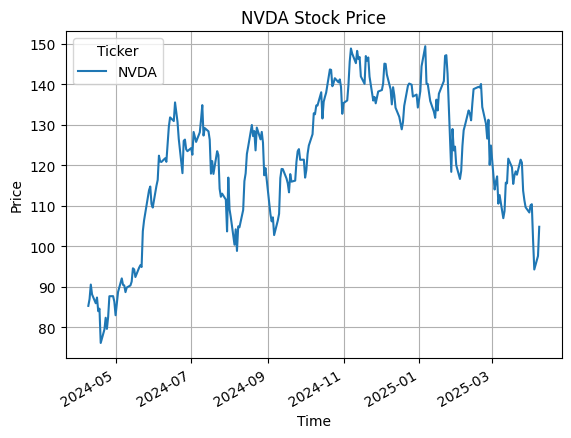

In [10]:
df["Close"].plot()
plt.title("NVDA Stock Price")
plt.ylabel("Price")
plt.xlabel("Time")
plt.grid(which="major")

In [12]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [14]:
df.describe()

Price,Close,High,Low,Open,Volume,Prev Close
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
count,251.000000,251.000000,251.000000,251.000000,2.510000e+02,251.000000
mean,121.272207,123.744399,118.711742,121.451955,3.134999e+08,121.201512
std,17.364402,17.453701,17.363372,17.604083,1.279690e+08,17.467348
min,76.174973,80.046700,75.581173,78.078345,9.525440e+07,76.174973
25%,111.496250,115.396723,109.348488,112.447667,2.222086e+08,111.496250
50%,123.509560,125.019886,119.998968,123.088674,2.885044e+08,123.509560
75%,135.167572,138.457265,133.002768,136.357760,3.779555e+08,135.167572
max,149.416245,153.115916,147.806407,153.015919,8.751980e+08,149.416245


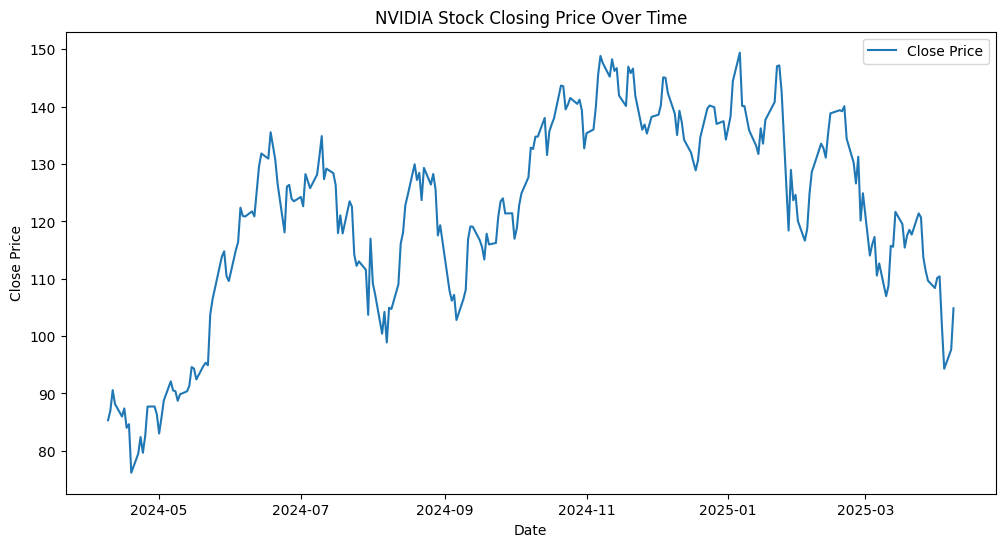

In [15]:
# Time-Series Plot of Closing Price

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('NVIDIA Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

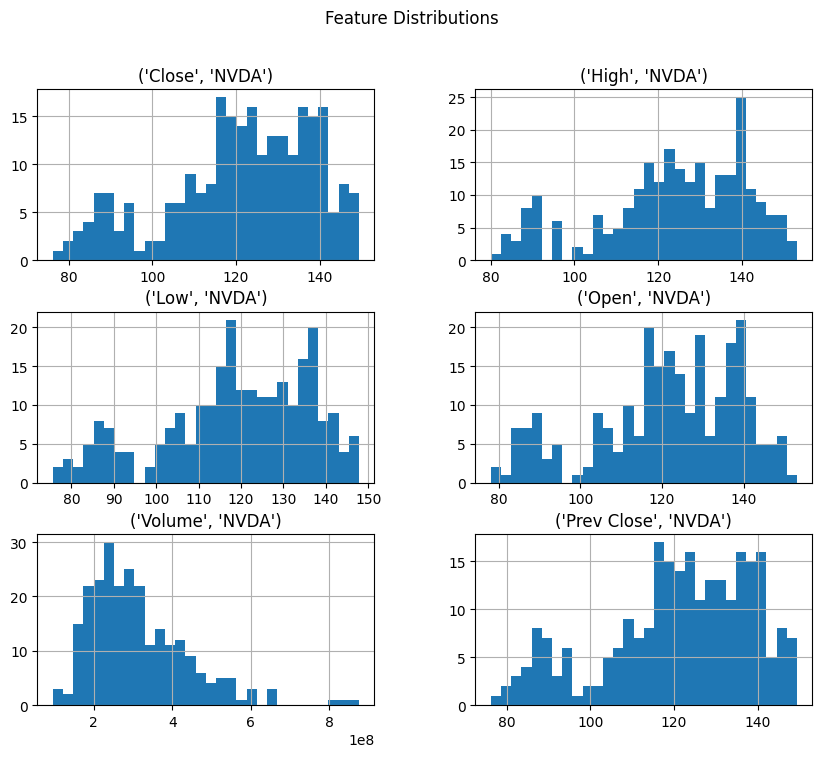

In [16]:
# Histogram for distributions
df.hist(figsize=(10, 8), bins=30)
plt.suptitle("Feature Distributions")
plt.show()

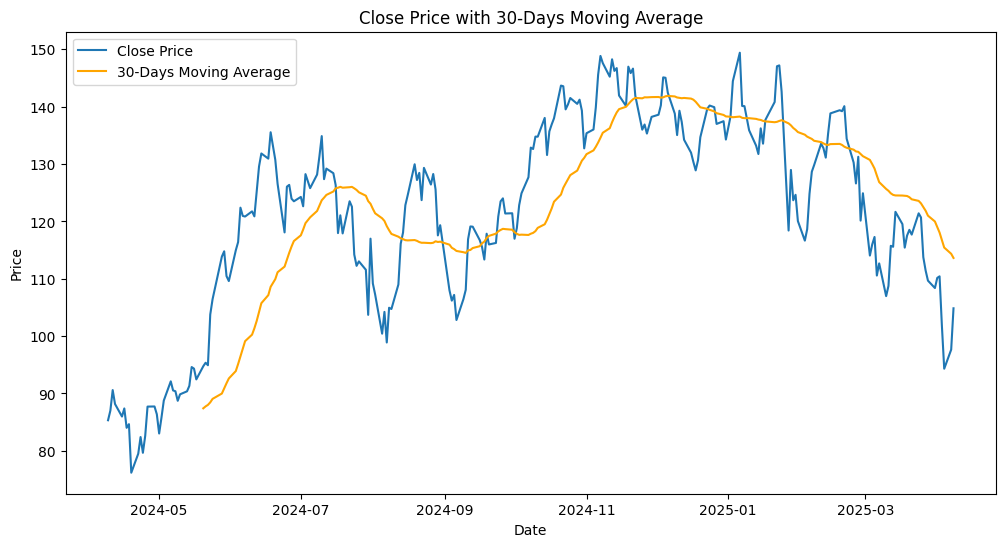

In [17]:
# Trend Analysis (Rolling Mean)

df['Close_30Days_Mean'] = df['Close'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['Close_30Days_Mean'], label='30-Days Moving Average', color='orange')
plt.title('Close Price with 30-Days Moving Average')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

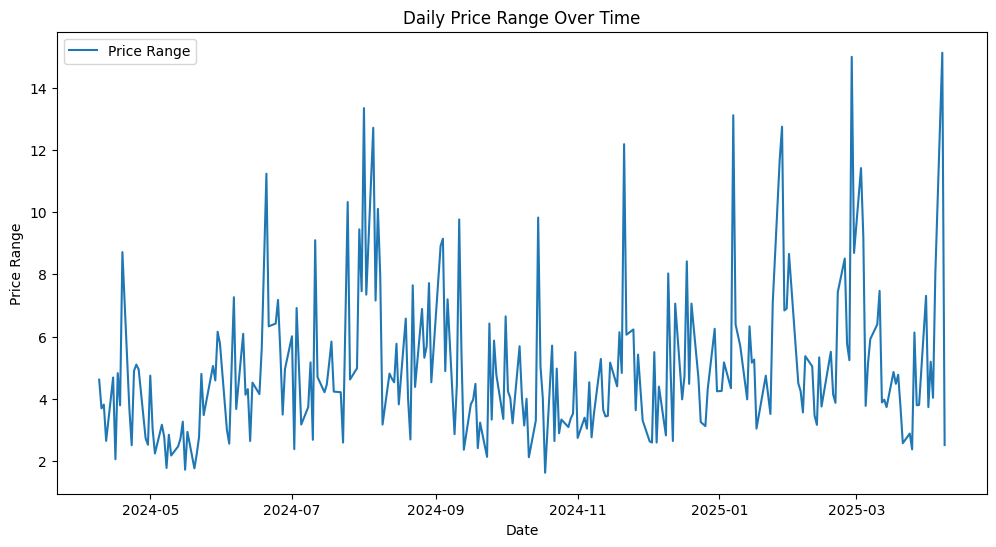

In [18]:
# Insight and Analysis - Price Range Analysis

df['Price Range'] = df['High'] - df['Low']
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price Range'], label='Price Range')
plt.title('Daily Price Range Over Time')
plt.xlabel('Date')
plt.ylabel('Price Range')
plt.legend()
plt.show()

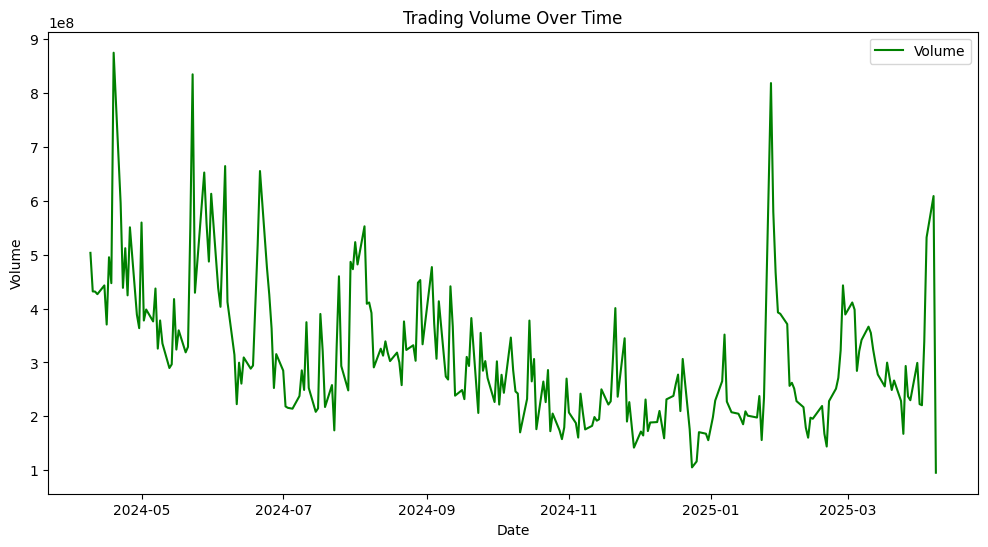

In [19]:
# Volume Analysis

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Volume'], label='Volume', color='green')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

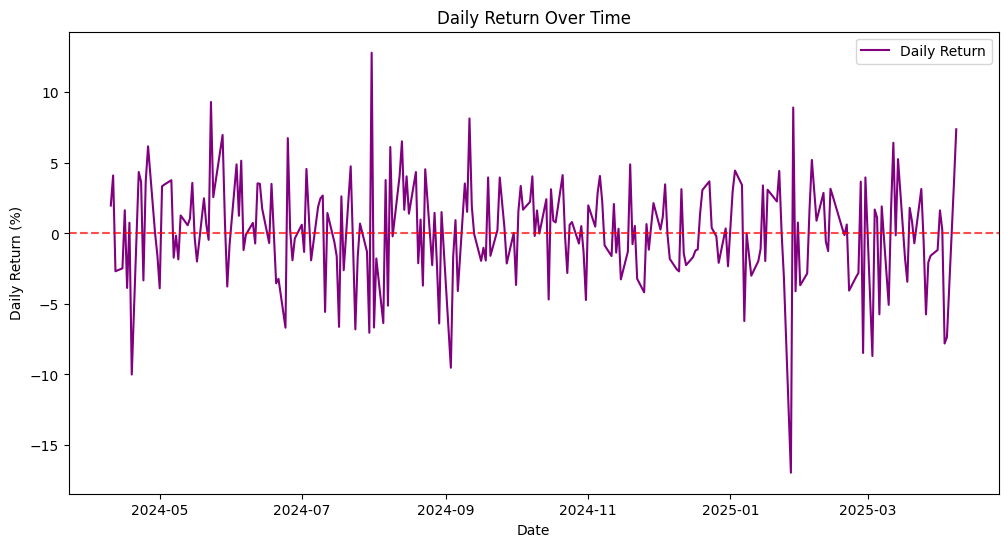

In [20]:
# Advance Analysis
# Volatility Analysis 
df['Daily Return'] = df['Close'].pct_change() * 100

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily Return'], label='Daily Return', color='purple')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.title('Daily Return Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.show()

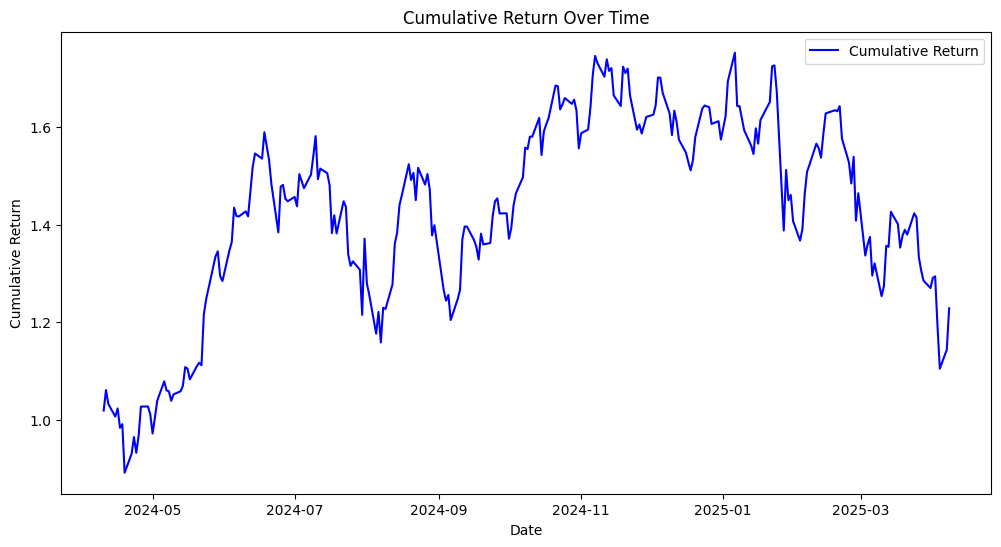

In [21]:
# Cumulative Returns
df['Cumulative Return'] = (1 + df['Daily Return'] / 100).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Cumulative Return'], label='Cumulative Return', color='blue')
plt.title('Cumulative Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()


### Predictive Model

In [22]:
# Features - Moving Average, Price Range, Daily Return

df['Price Range'] = df['High'] - df['Low']
df['Daily Return'] = df['Close'].pct_change()
df['7-Day Moving Avg'] = df['Close'].rolling(window=7).mean()
df['30-Day Moving Avg'] = df['Close'].rolling(window=30).mean()

# Drop rows with NaN values (created by rolling windows)
df.dropna(inplace=True)

# Define the features and target
X = df[['Open', 'High', 'Low', 'Volume', 'Price Range', 'Daily Return', '7-Day Moving Avg', '30-Day Moving Avg']]
Y = df['Close']

In [29]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500, 
    max_depth=10, 
    learning_rate=0.01, 
    objective='reg:pseudohubererror',  # More robust
    random_state=42
)

In [30]:
from xgboost import XGBRegressor, XGBClassifier

# Regression
xgb_reg = XGBRegressor(objective='reg:squarederror', n_estimators=100)

# Classification
xgb_clf = XGBClassifier(objective='binary:logistic', n_estimators=100)

In [31]:
df['Target'] = df['Close'].shift(-1)  # Predict next day's close
df.dropna(inplace=True)  # Drop last row

# Update target variable
Y = df['Target']

In [32]:
# Review the columns
print(df.columns)

MultiIndex([(            'Close', 'NVDA'),
            (             'High', 'NVDA'),
            (              'Low', 'NVDA'),
            (             'Open', 'NVDA'),
            (           'Volume', 'NVDA'),
            (       'Prev Close', 'NVDA'),
            ('Close_30Days_Mean',     ''),
            (      'Price Range',     ''),
            (     'Daily Return',     ''),
            ('Cumulative Return',     ''),
            ( '7-Day Moving Avg',     ''),
            ('30-Day Moving Avg',     ''),
            (           'Target',     '')],
           names=['Price', 'Ticker'])


c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


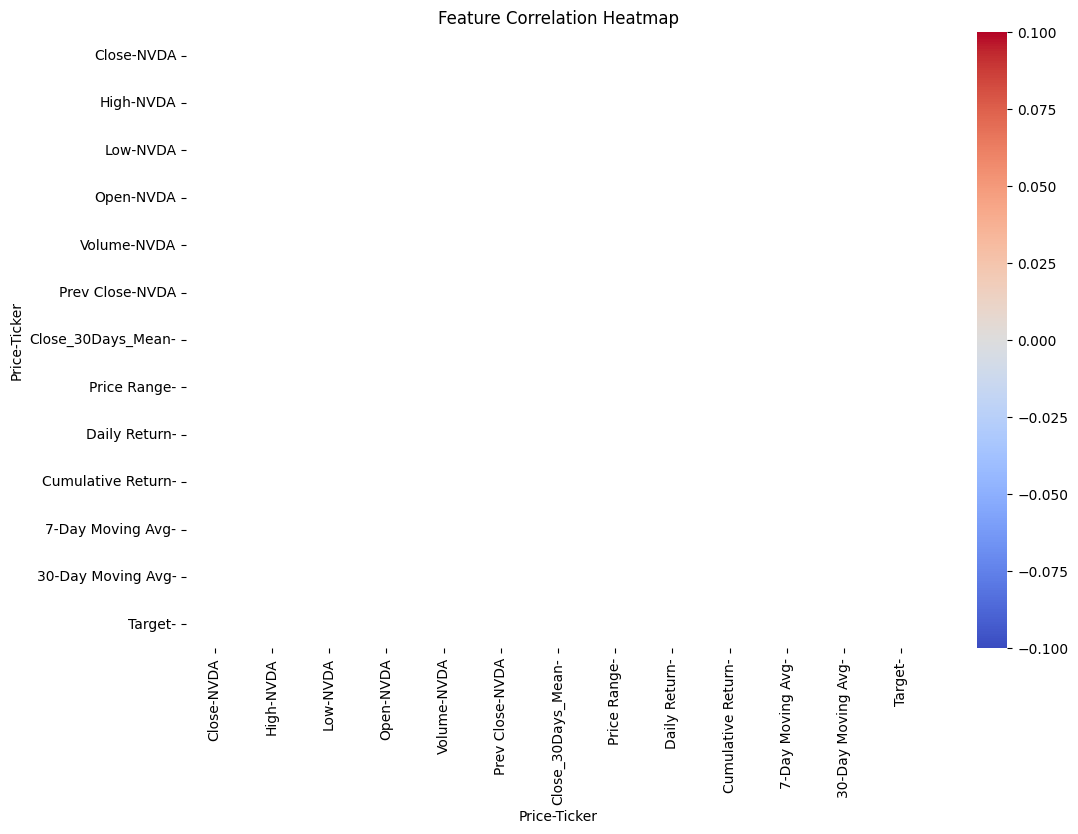

In [33]:
# Data Distribution Review 
#Correlation and Future Importance

import seaborn as sns

#Check feature correlation with target
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [34]:
#Removing Some Features¶
#Remove weak or redundant features:
X = df[['Open', 'High', 'Low', 'Volume']]  # Remove weak features